In [1]:
from system import *

e_field = zero_field()
b_field = t89(1)
system  = System(e_field, b_field)

Load IGRF coefficients ...


In [2]:
system.load("5000_12Re_1MeV_20pa")

Loaded files containing 916.10 megabytes of information.


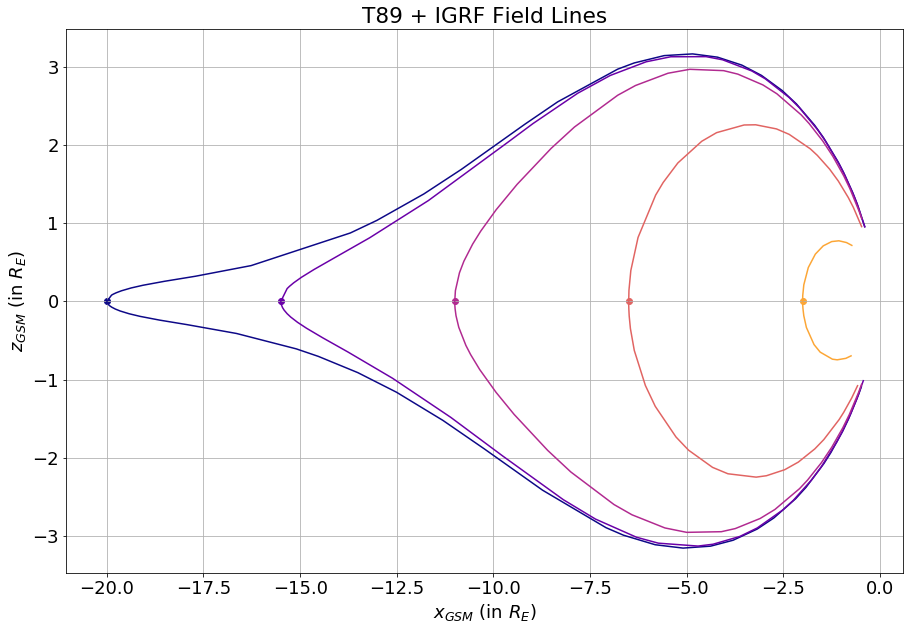

In [3]:
from field_utils import *

plt.figure(figsize=(15, 10))
plt.rcParams.update({'font.size': 18})

n = 5
for i, x in enumerate(np.linspace(-20 * Re, -2 * Re, n)):
    rr = field_line(b_field, np.array([x, 0, 0]), 1e1)
    r_min = field_reversal(b_field, rr)
    
    plt.plot(rr[:, 0] / Re, rr[:, 2] / Re, color=plt.cm.plasma(i / n))
    plt.scatter(r_min[0] / Re, r_min[2] / Re, color=plt.cm.plasma(i / n))
    
plt.grid()
plt.xlabel('$x_{GSM}$ (in $R_E$)')
plt.ylabel('$z_{GSM}$ (in $R_E$)')
plt.title('T89 + IGRF Field Lines')
plt.show()

In [3]:
system.populate_by_eq_pa(5000,
                         delta(12),
                         delta(1e6),
                         delta(np.radians(20)),
                         uniform(0, 2*np.pi)
                        )

100%|██████████| 5000/5000 [00:22<00:00, 217.41it/s]


In [4]:
system.solve(2, 1e-4)

100%|██████████| 5000/5000 [05:52<00:00, 14.18it/s]


In [5]:
system.save("5000_12Re_1MeV_20pa")

Saved files containing 916.10 megabytes of information.


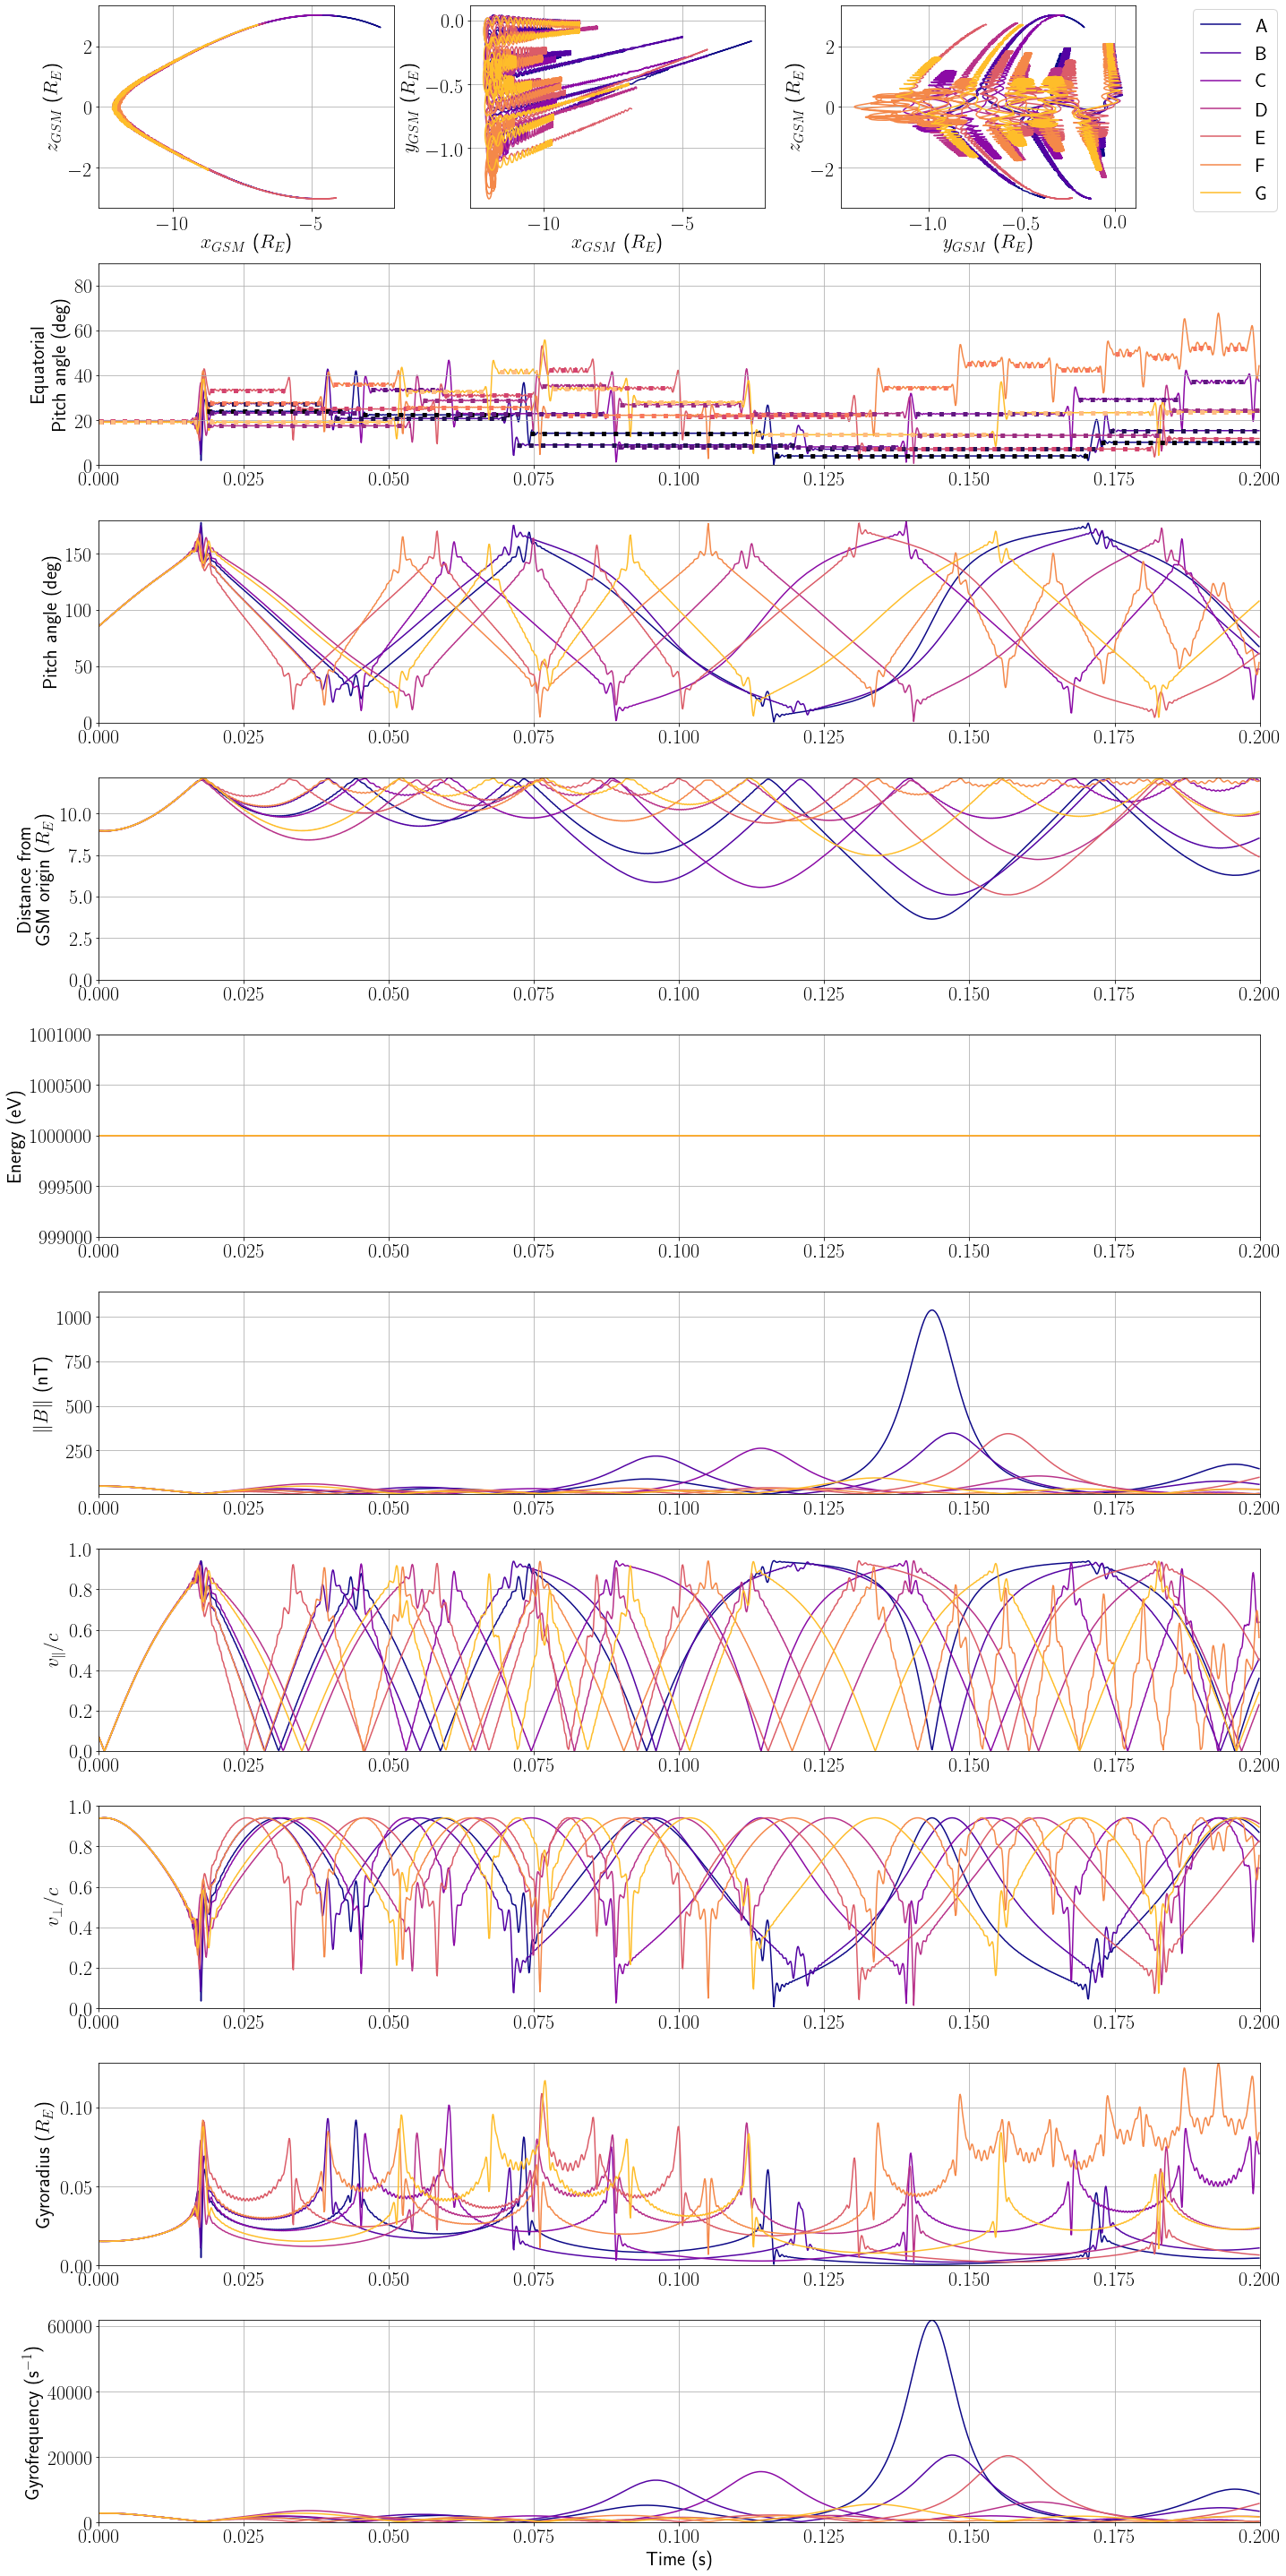

In [4]:
system.plot([523, 2380, 135, 4913, 27, 559, 1332])

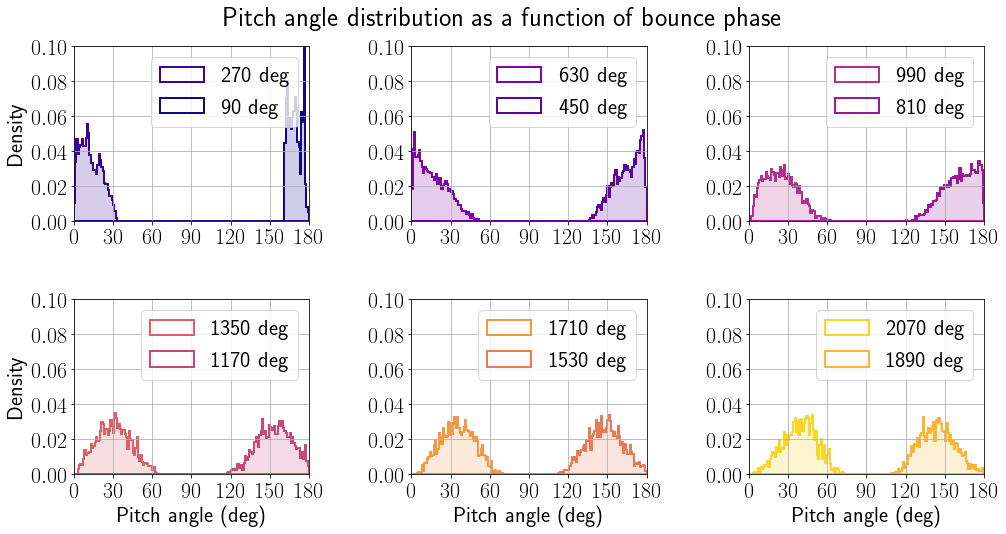

In [5]:
from math import ceil

phase_list = [(2*k + 1) * np.pi / 2 for k in range(12)]
colors = plt.cm.plasma([i / len(phase_list) for i in range(len(phase_list))])
phases = []
fig = plt.figure(figsize=(15, 8))

for phase in phase_list:
    phases.append(get_pas_at_bounce_phase(system.history, phase))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.hist(phases[(2 * i):(2 * i) + 2], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[(2 * i):(2 * i) + 2], density=True, label=[f'{ceil(k)} deg' for k in np.degrees(phase_list[(2 * i):(2 * i) + 2])])
    plt.hist(phases[(2 * i):(2 * i) + 2], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[(2 * i):(2 * i) + 2], density=True)
    plt.grid()
    plt.xlim([0, 180])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 181, 30))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 2:
        plt.xlabel('Pitch angle (deg)')

fig.suptitle('Pitch angle distribution as a function of bounce phase')
plt.tight_layout(pad=2)
plt.show()

  3%|▎         | 1/30 [00:01<00:37,  1.29s/it]


100%|██████████| 6/6 [04:01<00:00, 40.21s/it]


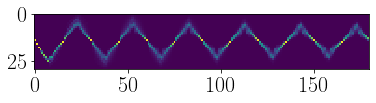

In [214]:
bins = 30

image = np.zeros((bins, bins * 6))

for i in tqdm.tqdm(range(6)):
    phases = np.linspace(0, 2*np.pi, bins, endpoint=False)
    for j in tqdm.tqdm(range(len(phases))):
        image[:, bins * i + j] = np.sqrt(np.histogram(get_pas_at_bounce_phase(system.history, phases[j] + 2*np.pi*i), bins=np.linspace(0, 180, bins + 1), density=True)[0])
        
plt.imshow(image)
plt.show()

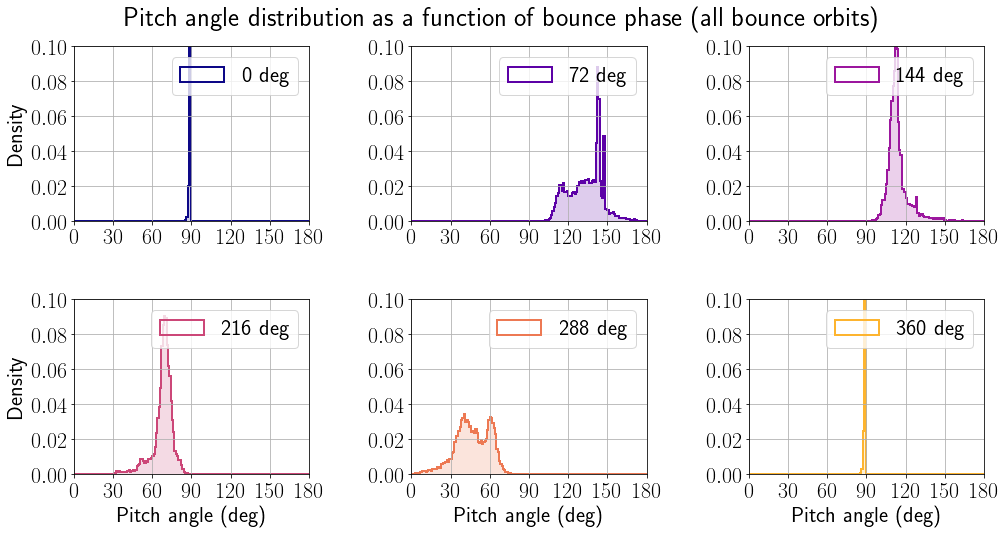

In [31]:
from math import ceil

phase_list = np.linspace(0, 2*np.pi, 6)
colors = plt.cm.plasma([i / len(phase_list) for i in range(len(phase_list))])
phases = []
fig = plt.figure(figsize=(15, 8))

for phase in phase_list:
    phases.append(get_pas_at_bounce_phase_all_t(system.history, phase))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.hist(phases[i], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{ceil(np.degrees(phase_list[i]))} deg')
    plt.hist(phases[i], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 180])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 181, 30))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 2:
        plt.xlabel('Pitch angle (deg)')

fig.suptitle('Pitch angle distribution as a function of bounce phase (all bounce orbits)')
plt.tight_layout(pad=2)
plt.show()

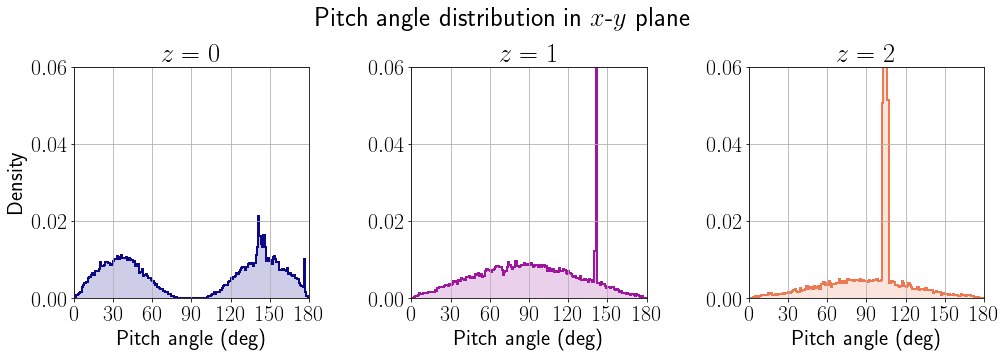

In [21]:
def pitch_angles_in_xy_plane(history, intrinsic, z_gsm):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])
    
    pas = pitch_angle(history)
    history_container = []
    
    for i in range(num_particles):
        centered = history[i, :, 0, 2] / Re - z_gsm
        crossings = np.where(np.diff(np.sign(centered)))[0]
        
        history_container = np.append(history_container, pas[i, crossings].flatten())
        
    return np.array(history_container).flatten()


z_list = [0, 1, 2]
colors = plt.cm.plasma([k / len(z_list) for k in range(len(z_list))])
pas = []
fig = plt.figure(figsize=(15, 5.5))

for z in z_list:
    pas.append(pitch_angles_in_xy_plane(system.history, system.ics[:, 4, 0:2], z))
    
for i, pa in enumerate(pas):
    plt.subplot(1, 3, i + 1)
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'$z = {z_list[i]}$')
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    
    plt.xlabel('Pitch angle (deg)')
    plt.grid()
    plt.xlim([0, 180])
    plt.xticks(np.arange(0, 181, 30))
    plt.ylim([0, 0.06])
    plt.yticks(np.arange(0, 0.07, 0.02))
    plt.title(f'$z = {z_list[i]}$')
    
    if i == 0:
        plt.ylabel('Density')       

fig.suptitle('Pitch angle distribution in $x$-$y$ plane')
plt.tight_layout(pad=2)
plt.show()

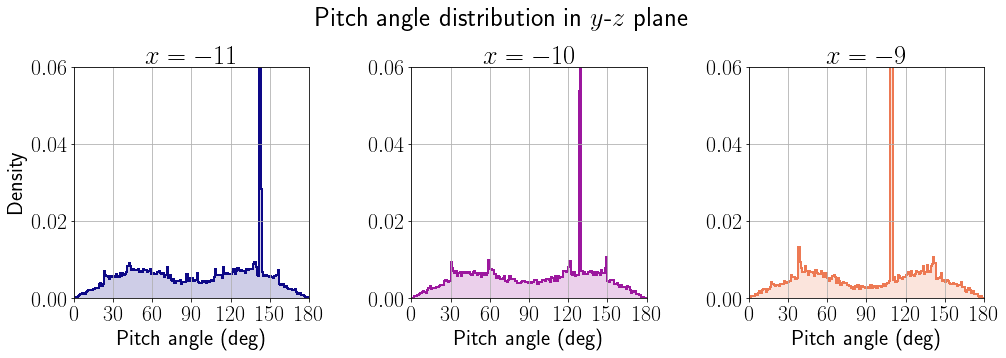

In [22]:
def pitch_angles_in_yz_plane(history, intrinsic, x_gsm):
    num_particles = len(history[:, 0, 0, 0])
    steps = len(history[0, :, 0, 0])
    
    pas = pitch_angle(history)
    history_container = []
    
    for i in range(num_particles):
        centered = history[i, :, 0, 0] / Re - x_gsm
        crossings = np.where(np.diff(np.sign(centered)))[0]
        
        history_container = np.append(history_container, pas[i, crossings].flatten())
        
    return np.array(history_container).flatten()


x_list = [-11, -10, -9]
colors = plt.cm.plasma([k / len(x_list) for k in range(len(x_list))])
pas = []
fig = plt.figure(figsize=(15, 5.5))

for x in x_list:
    pas.append(pitch_angles_in_yz_plane(system.history, system.ics[:, 4, 0:2], x))
    
for i, pa in enumerate(pas):
    plt.subplot(1, 3, i + 1)
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'$x = {x_list[i]}$')
    plt.hist(pa, bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    
    plt.xlabel('Pitch angle (deg)')
    plt.grid()
    plt.xlim([0, 180])
    plt.xticks(np.arange(0, 181, 30))
    plt.ylim([0, 0.06])
    plt.yticks(np.arange(0, 0.07, 0.02))
    plt.title(f'$x = {x_list[i]}$')
    
    if i == 0:
        plt.ylabel('Density')       

fig.suptitle('Pitch angle distribution in $y$-$z$ plane')
plt.tight_layout(pad=2)
plt.show()

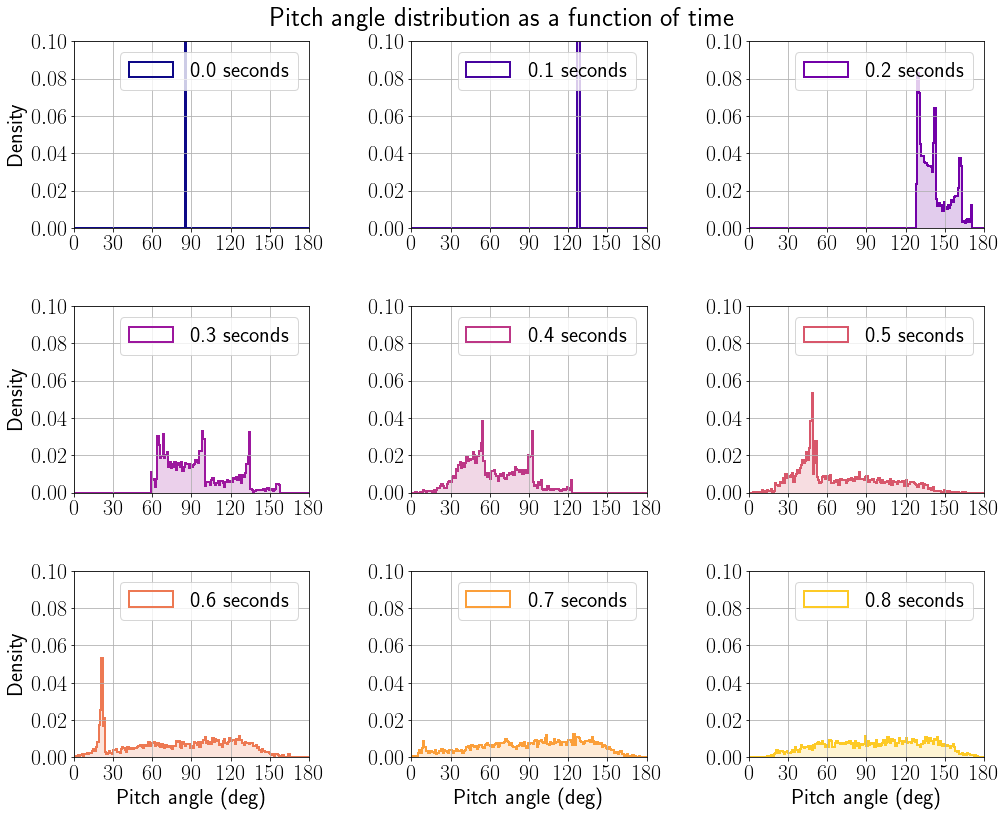

In [29]:
pas = pitch_angle(system.history)

times = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
colors = plt.cm.plasma([k / len(times) for k in range(len(times))])

fig = plt.figure(figsize=(15, 12))

for i, t in enumerate(times):
    plt.subplot(3, 3, i + 1)
    plt.hist(pas[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{t} seconds')
    plt.hist(pas[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 180])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 181, 30))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 5:
        plt.xlabel('Pitch angle (deg)')

fig.suptitle('Pitch angle distribution as a function of time')
plt.tight_layout(pad=2)
plt.show()

In [48]:
eq_pas_extracted = get_eq_pas(b_field, system.history, system.ics[:, 4, 0:2])

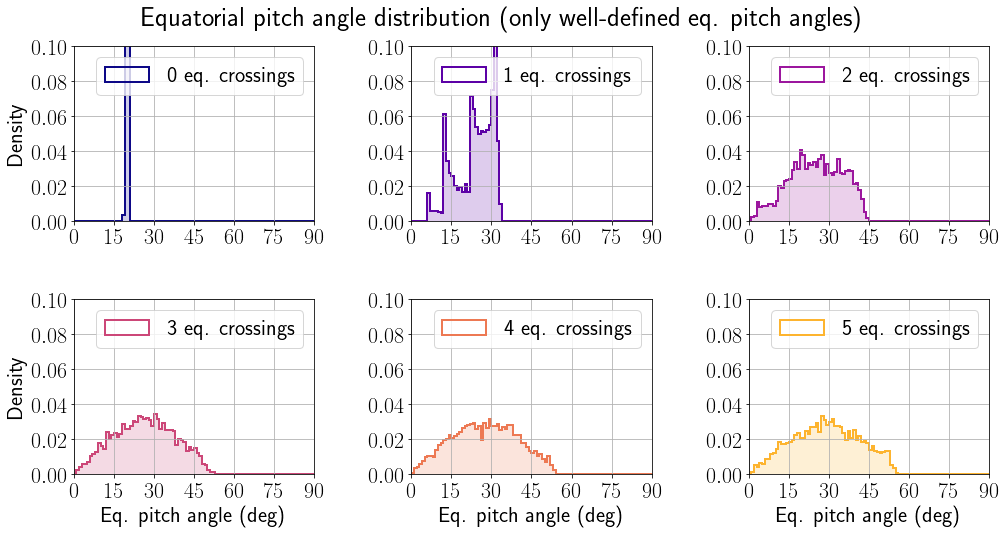

In [91]:
xings = [0, 1, 2, 3, 4, 5]
colors = plt.cm.plasma([k / len(xings) for k in range(len(xings))])

fig = plt.figure(figsize=(15, 8))

for i, n in enumerate(xings):
    plt.subplot(2, 3, i + 1)
    plt.hist(eq_pas_extracted[np.where(eq_pas_extracted[:, n, 0] != -1)[0], n, 0], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{n} eq. crossings')
    plt.hist(eq_pas_extracted[np.where(eq_pas_extracted[:, n, 0] != -1)[0], n, 0], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 90])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 91, 15))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 2:
        plt.xlabel('Eq. pitch angle (deg)')

fig.suptitle('Equatorial pitch angle distribution (only well-defined eq. pitch angles)')
plt.tight_layout(pad=2)
plt.show()

In [ ]:
eq_pas_instantaneous = eq_pitch_angle_from_moment(system.history, system.ics[:, 4, 0:2])

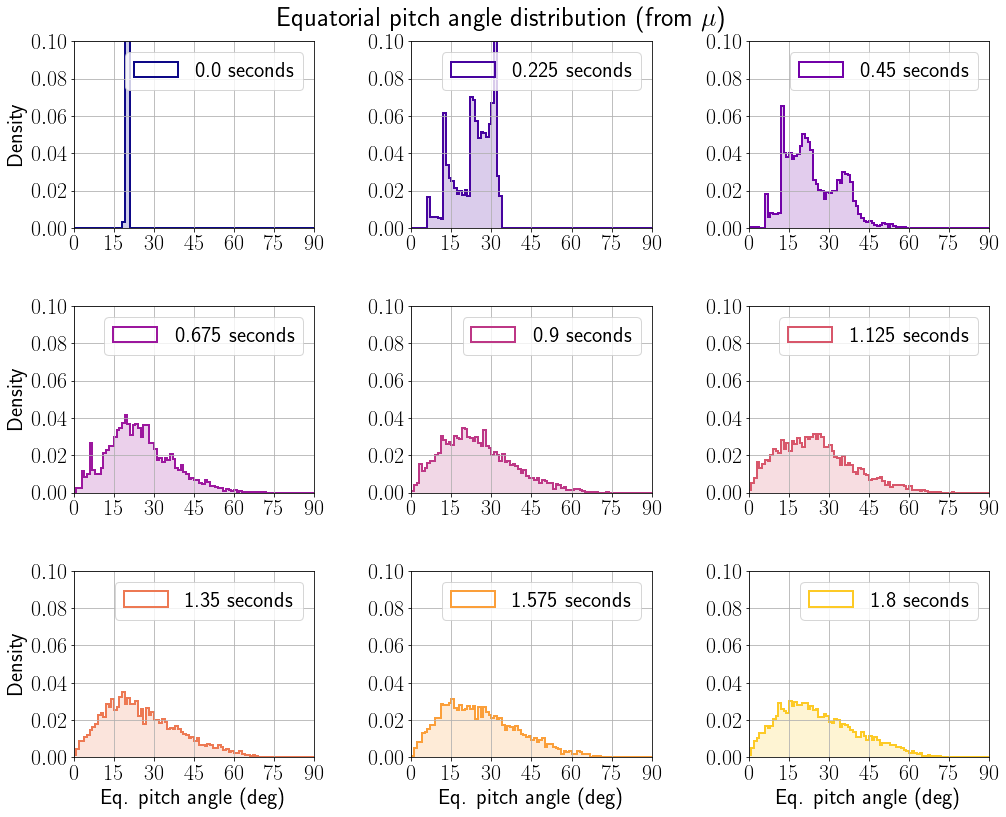

In [86]:
times = np.linspace(0, 1.8, 9)
colors = plt.cm.plasma([k / len(times) for k in range(len(times))])

fig = plt.figure(figsize=(15, 12))

for i, t in enumerate(times):
    plt.subplot(3, 3, i + 1)
    plt.hist(eq_pas_instantaneous[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='step', linewidth=2, color=colors[i], density=True, label=f'{t} seconds')
    plt.hist(eq_pas_instantaneous[:, int(t / 1e-3)], bins=np.arange(0, 181, 1), histtype='stepfilled', alpha=0.2, color=colors[i], density=True)
    plt.grid()
    plt.xlim([0, 90])
    plt.ylim([0, 0.1])
    plt.legend()
    plt.yticks(np.arange(0, 0.11, 0.02))
    plt.xticks(np.arange(0, 91, 15))
    
    if i % 3 == 0:
        plt.ylabel('Density')
    
    if i > 5:
        plt.xlabel('Eq. pitch angle (deg)')

fig.suptitle('Equatorial pitch angle distribution (from $\mu$)')
plt.tight_layout(pad=2)
plt.show()

In [100]:
@njit
def per_particle_diffusion(history, dt):
    num_particles = len(history[:, 0, 0, 0])
    steps         = len(history[0, :, 0, 0])

    v                  = velocity(history)
    v_par, v_par_mag   = velocity_par(history)
    indices            = np.arange(0, steps) * dt

    mus = np.zeros((num_particles, steps - 1))
    D_uus = np.zeros((num_particles, steps - 1))

    for i in range(num_particles):
        for j in range(steps - 1):
            mu_begin    = v_par_mag[i, j] / np.linalg.norm(v[i, j])
            mu_end      = v_par_mag[i, j + 1] / np.linalg.norm(v[i, j + 1])
            D_uus[i, j] = (mu_end - mu_begin)**2 / (2 * dt)
            mus[i, j]   = (mu_end + mu_begin) / 2
            
    return mus, D_uus

In [102]:
mus, D_uus = per_particle_diffusion(system.history, 1e-3)

In [156]:
def average_over_mus(mus, D_uus, i, bins=20):
    D_uu_averaged = [[] for k in range(bins)]
    k = 1.0 / bins
    
    for j in range(len(mus[:, i])):
        bin_ind = floor(mus[j, i] // k)
        D_uu_averaged[bin_ind].append(D_uus[j, i])
        
    for i, d in enumerate(D_uu_averaged):
        if len(d) == 0:
            D_uu_averaged[i].append(0)
            
    D_uu_final = np.array([np.mean(k) for k in D_uu_averaged])
    return D_uu_final

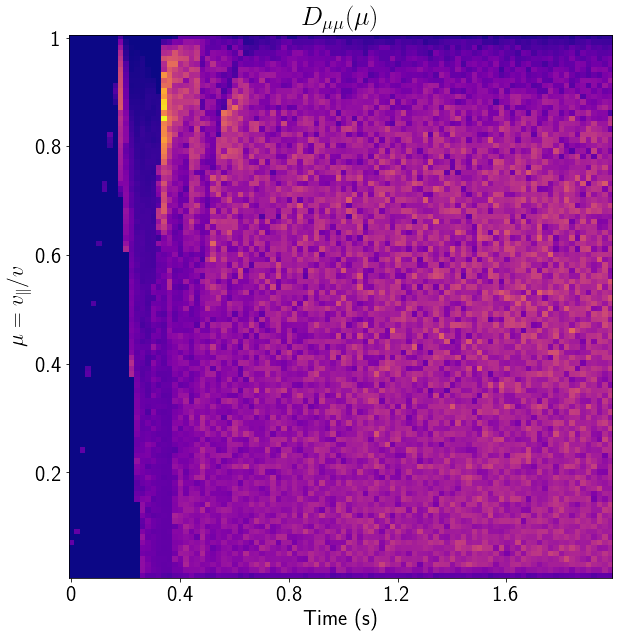

In [202]:
bins = 100

D_uu_map = np.zeros((bins, bins))

for i, ind in enumerate(np.linspace(0, 1998, bins)):
    D_uu_map[:, i] = np.flip(np.sqrt(average_over_mus(mus, D_uus, int(ind), bins)))
    
plt.figure(figsize=(15, 10))
plt.imshow(D_uu_map, cmap='plasma')
plt.title('$D_{\mu\mu}(\mu)$')
plt.ylabel(r'$\mu = v_{\parallel}/v$')
plt.xlabel('Time (s)')
plt.yticks([0, 20, 40, 60, 80], [1, 0.8, 0.6, 0.4, 0.2])
plt.xticks([0, 20, 40, 60, 80], [0, 0.4, 0.8, 1.2, 1.6])
plt.show()

In [106]:
def compare_diff_coef(indices):
    fig = plt.figure(figsize=(15, 5))
    plt.subplot(121)
    for i in indices:
        plt.hist(D_uus_inst[:, i], bins=30, histtype='step', density=True)

    plt.subplot(122)
    for i in indices:
        plt.hist(D_uus_tot[:, i], bins=np.arange(0, 5, 1e-2), histtype='step', density=True)

    plt.show()

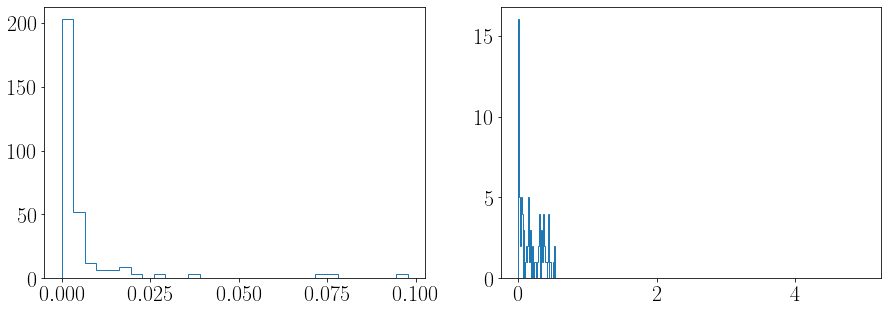

In [107]:
compare_diff_coef([8000])